<a href="https://colab.research.google.com/github/jecampagne/JaxTutos/blob/main/JAX_MultiGPus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In developpement...

# Goal
Sample a 2D function $f(x,y)$ to produce a 2D image.
- à-la-numpy
- à la JAX single unit via `vmap`
- à la JAX 4 GPUs via different solutions

nb. we will revisit the Julia set production

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [19]:
jax.__version__

'0.4.26'

In [3]:
# the function
@jax.jit
def func(x,y):
    return jnp.sin(jnp.sqrt(x**2+y**2))

In [5]:
# where I want to sample to get a 2D image
Npix=2048
xvals = jnp.linspace(-2*jnp.pi,2*jnp.pi,Npix)
yvals = jnp.linspace(-2*jnp.pi,2*jnp.pi,Npix)
jax.debug.visualize_array_sharding(xvals) # where are my data

  CPU 0  
         

## A-la-numpy

In [6]:
X,Y = jnp.meshgrid(xvals,yvals)
jax.debug.visualize_array_sharding(X)
img = func(X,Y)


                         
                         
                         
                         
                         
          CPU 0          
                         
                         
                         
                         
                         

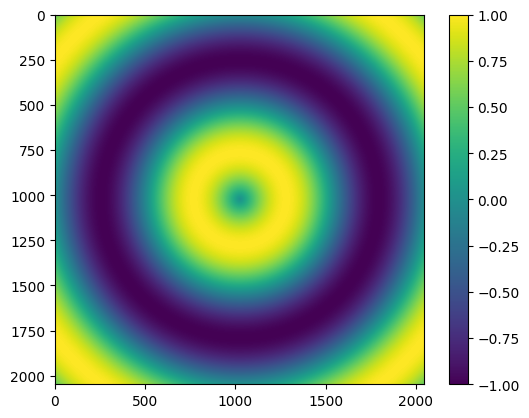

In [14]:
plt.imshow(img);plt.colorbar();

## Using JAX vmap

- one solution is using the meshgrid X,Y (2D arrays)
- one solution is using directly the 1D sampling arrays in x-axes and y-axes (no duplication of  sampling location information)

In [15]:
# if one has a non smart vectorized func: usage of vmap (1)
mapped = jax.vmap(func, in_axes=(0, 0))
img0 = jax.jit(mapped)(X,Y)
print(jnp.allclose(img,img0))
jax.debug.visualize_array_sharding(img0)

True


                         
                         
                         
                         
                         
          CPU 0          
                         
                         
                         
                         
                         

In [16]:
# vmap (2) using directly the xvals, yvals vectors
mapped = jax.vmap(jax.vmap(func, in_axes=(None, 0)), in_axes=(0, None))
img1 = jax.jit(mapped)(xvals,yvals)
print(jnp.allclose(img,img1))
jax.debug.visualize_array_sharding(img1)

True


                         
                         
                         
                         
                         
          CPU 0          
                         
                         
                         
                         
                         

# Using JAX multi-GPUs (TPUs)

- using the X,Y 2D meshgrid arrays


In [ ]:
from jax.sharding import Mesh, NamedSharding,  PartitionSpec as P
from jax.experimental import mesh_utils
from jax.experimental.shard_map import shard_map

In [17]:
# The JAX API for multi-devices is changing over the time, so this is the way 21th May 2024 (v 0.4.26)
devices = mesh_utils.create_device_mesh((2, 2))  # 2D grid with our 4 GPUs
mesh = Mesh(devices, ('x', 'y'))
sharding = NamedSharding(mesh, P('x', 'y'))
print(sharding)

NameError: name 'mesh_utils' is not defined

In [ ]:
shard_mapped = shard_map(func, mesh=mesh, in_specs=P('x','y'), out_specs=P('x','y'))
img2 = jax.jit(shard_mapped)(X,Y)
print(jnp.allclose(img,img2))
jax.debug.visualize_array_sharding(img2)

- using the 1D sampling arrays


In [21]:
mapped = jax.vmap(jax.vmap(func, in_axes=(None, 0)), in_axes=(0, None))
shard_mapped=shard_map(mapped, mesh=mesh, in_specs=(P('x'), P('y')), out_specs=P('x','y'))
img3 = jax.jit(shard_mapped)(xvals, yvals)
print(jnp.allclose(img,img3))
jax.debug.visualize_array_sharding(img3)

NameError: name 'shard_map' is not defined

- using automatic sharding (probably the 1st thing to test)

In [ ]:
x_sharded = jax.device_put(xvals, NamedSharding(mesh, P('x')))
y_sharded = jax.device_put(yvals, NamedSharding(mesh, P('y')))
mapped = jax.vmap(jax.vmap(func, in_axes=(None, 0)), in_axes=(0, None))
img4 = jax.jit(mapped)(x_sharded, y_sharded) # You let jit to perform th shard_mapping automatically
print(jnp.allclose(img,img4))
jax.debug.visualize_array_sharding(img4)